# Import libraries

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Transform Object Definition

For train data set we will use rotation and horizontol flip to increase data content to cover wider different figures

In [7]:
train_transform = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomHorizontalFlip(),
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])

For test data set we will only use resize,centercrop, to tensor and normalization transform

In [8]:
test_transform = transforms.Compose([
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Importing image data using dataloader

In [9]:
root = 'xray/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
#we can just cast train root completely in imagefolder() paranthesis
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)



train_loader = DataLoader(train_data,batch_size=10,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data,batch_size=10,pin_memory=True)

class_names = train_data.classes # specify classes

In [10]:
#To display class names we can write 
class_names

['NORMAL', 'PNEUMONIA']

In [11]:
len(train_data)

5216

In [12]:
len(test_data)

624

# Displaying first batch of the image

In [13]:
for i,(images,labels) in enumerate(train_loader):
    break

In [14]:
images.shape

torch.Size([10, 3, 224, 224])

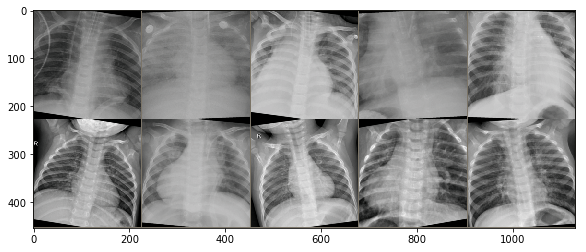

In [15]:
im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

# Convolutional Neural Network

In [16]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)
                 

In [17]:
torch.manual_seed(101)

In [18]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
model = model.to(device)

In [20]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

Checking model parameters

In [21]:
for param in model.parameters():
    print(param.numel())

162
6
864
16
5598720
120
10080
84
168
2


# Training

In [22]:
import time
start_time = time.time()

epochs = 3

#Limits on numbers of batches if you want train faster(Not mandatory)
max_trn_batch = 800 # batch 10 image --> 8000 images total
max_tst_batch = 300 # batch 10 image --> 3000 images total


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        X_train,y_train = X_train.to(device),y_train.to(device)
        
        #optinal limit number of batches
        if b == max_trn_batch:
            break
        b = b + 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr = trn_corr + batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print('Epoch:  {} Loss:  {} Accuracy:  {}'.format(i,loss,trn_corr.item()*100/(10*b)))
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    #test set
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            X_test,y_test = X_test.to(device),y_test.to(device)
            
            #Optional
            if b==max_tst_batch:
                break
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr
    
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
    
total_time = time.time() - start_time
print(f'Total Time: {total_time/60}) minutes')

Epoch:  0 Loss:  0.027812758460640907 Accuracy:  89.45
Epoch:  0 Loss:  0.4917529225349426 Accuracy:  90.8
Epoch:  1 Loss:  0.49675703048706055 Accuracy:  94.7
Epoch:  1 Loss:  0.004346427507698536 Accuracy:  94.9
Epoch:  2 Loss:  0.01353205181658268 Accuracy:  95.85
Epoch:  2 Loss:  0.016714122146368027 Accuracy:  95.85
Total Time: 9.611939430236816) minutes


# Saving the trained model

In [70]:
torch.save(model.state_dict(),'CatandDog.pt')

# Result visualization

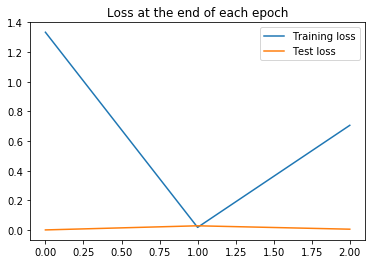

In [71]:
plt.plot(train_losses,label='Training loss')
plt.plot(test_losses,label='Test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

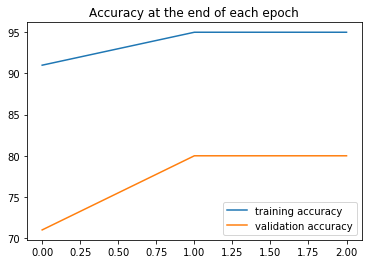

In [72]:
plt.plot([t*100/5216 for t in train_correct], label='training accuracy')
plt.plot([t*100/624 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();